In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [3]:
flights = pd.read_csv('itineraries.csv')

flights['flightDate'] = pd.to_datetime(flights['flightDate'])
flights['day_of_week'] = flights['flightDate'].dt.day_name()

In [4]:
import re

def convert_duration_to_seconds(duration_str):
    match = re.match(r'PT(\d+)H(\d+)M', duration_str)
    if match:
        hours, minutes = map(int, match.groups())
        return hours * 3600 + minutes * 60
    else:
        return 0

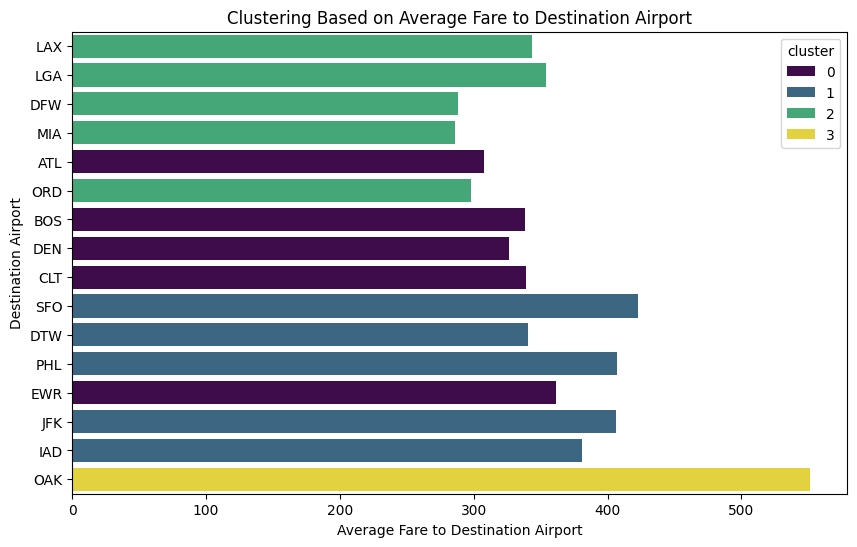

In [5]:
# research the reason for the clusters

flights['travelDurationSeconds'] = flights['travelDuration'].apply(convert_duration_to_seconds)

# Group flights by destination airport and count the frequency of each destination
destination_counts = flights['destinationAirport'].value_counts().reset_index()
destination_counts.columns = ['destinationAirport', 'frequency']

# Add additional features
destination_counts = destination_counts.merge(flights.groupby('destinationAirport')['totalFare'].mean().reset_index(), on='destinationAirport', how='left')
destination_counts.rename(columns={'totalFare': 'avg_fare'}, inplace=True)

destination_counts = destination_counts.merge(flights.groupby('destinationAirport')['travelDurationSeconds'].mean().reset_index(), on='destinationAirport', how='left')
destination_counts.rename(columns={'travelDurationSeconds': 'avg_travel_duration_seconds'}, inplace=True)

destination_counts['airline_count'] = flights.groupby('destinationAirport')['segmentsAirlineName'].nunique().reset_index()['segmentsAirlineName']

# Standardize the numeric features
scaler = StandardScaler()
numeric_features = ['frequency', 'avg_fare', 'avg_travel_duration_seconds', 'airline_count']
destination_counts[numeric_features] = scaler.fit_transform(destination_counts[numeric_features])

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
destination_counts['cluster'] = kmeans.fit_predict(destination_counts[numeric_features])


# Revert destination_counts DataFrame to original feature values
destination_counts[numeric_features] = scaler.inverse_transform(destination_counts[numeric_features])

# Plot the clusters using the original feature values
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_fare', y='destinationAirport', hue='cluster', data=destination_counts, palette='viridis', dodge=False)
plt.xlabel('Average Fare to Destination Airport')
plt.ylabel('Destination Airport')
plt.title('Clustering Based on Average Fare to Destination Airport')
plt.show()


                     Airline  frequency    avg_fare  \
0          American Airlines      75795  296.666181   
1                     United      62226  365.532919   
2                      Delta      61276  374.810623   
3            JetBlue Airways      15073  303.727763   
4            Spirit Airlines      13133  264.620518   
5            Alaska Airlines      12824  609.292592   
6          Frontier Airlines       3880  313.774052   
7                   Cape Air        366  558.377432   
8   Southern Airways Express        204  391.821275   
9       Sun Country Airlines        198  409.837374   
10              Boutique Air        133  485.130150   
11              Key Lime Air         66  307.331515   
12          Contour Airlines          3  645.066667   

    avg_travel_duration_seconds  destination_count  starting_airport  
0                  21801.223036                 16                16  
1                  26070.187060                 15                15  
2               

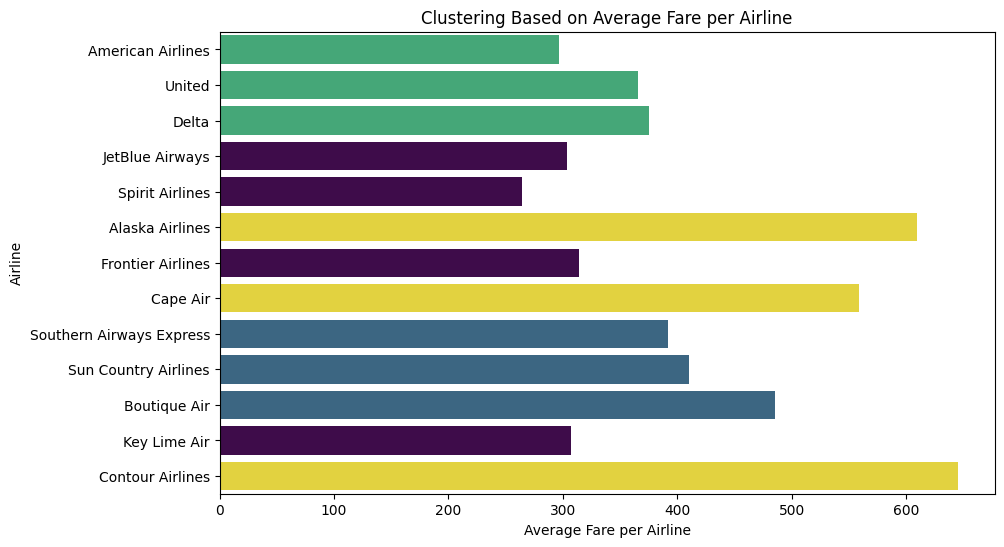

In [23]:
# separates the "||" and grabs the first airline that appears
flights['Airline'] = flights['segmentsAirlineName'].apply(lambda x: x.split('||')[0])

# groups by airlines and counts each airline
airline_counts = flights['Airline'].value_counts().reset_index()
airline_counts.columns = ['Airline', 'frequency']
#print(airline_counts)

# getting average fare for each airline
airline_counts = airline_counts.merge(flights.groupby('Airline')['totalFare'].mean().reset_index(), on='Airline', how='left') #merge on Airline
airline_counts.rename(columns={'totalFare': 'avg_fare'}, inplace=True)
#print(airline_counts)

#getting average distance for each airline
airline_counts = airline_counts.merge(flights.groupby('Airline')['travelDurationSeconds'].mean().reset_index(), on='Airline', how='left') #merge on Airline
airline_counts.rename(columns={'travelDurationSeconds': 'avg_travel_duration_seconds'}, inplace=True)
#print(airline_counts)

# get count of starting and destination airports for each airline
airline_counts['destination_count'] = flights.groupby('Airline')['destinationAirport'].nunique().reset_index()['destinationAirport']
airline_counts['starting_airport'] = flights.groupby('Airline')['startingAirport'].nunique().reset_index()['startingAirport']
print(airline_counts)

# numeric features for clustering
scaler = StandardScaler()
numeric_features = ['frequency', 'avg_fare', 'avg_travel_duration_seconds'] #'destination_count', 'starting_airport'
airline_counts[numeric_features] = scaler.fit_transform(airline_counts[numeric_features])

# k-means model here
kmeans = KMeans(n_clusters=4, random_state=42)
airline_counts['cluster'] = kmeans.fit_predict(airline_counts[numeric_features])

# get original values without scaling to make graph nicer
airline_counts[numeric_features] = scaler.inverse_transform(airline_counts[numeric_features])

plt.figure(figsize=(10, 6))
sns.barplot(x='avg_fare', y='Airline', hue='cluster', data=airline_counts, palette='viridis', dodge=False, legend=False)
plt.xlabel('Average Fare per Airline')
plt.ylabel('Airline')
plt.title('Clustering Based on Average Fare per Airline')
plt.show()


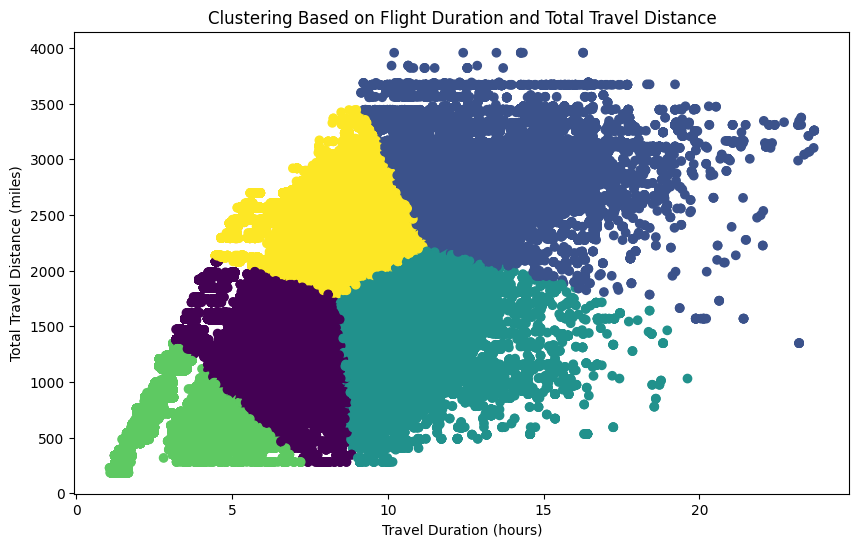

In [21]:
# Filter out flights with 0 travel duration
flights = flights[flights['travelDurationSeconds'] > 0]

# Convert travel duration from seconds to hours
flights['travelDurationHours'] = flights['travelDurationSeconds'] / 3600

# Select only numerical columns for clustering
numerical_columns = ['travelDurationHours', 'totalTravelDistance']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(flights[numerical_columns])

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_data)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
flights['cluster'] = kmeans.fit_predict(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(flights['travelDurationHours'], flights['totalTravelDistance'], c=flights['cluster'], cmap='viridis')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Total Travel Distance (miles)')
plt.title('Clustering Based on Flight Duration and Total Travel Distance')
plt.show()